# Install python 3.11 on Colab

In [ ]:
!sudo apt-get update
!sudo apt-get install python3.11 python3.11-dev python3.11-venv
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --config python3  # Then choose the number corresponding to Python 3.11 (e.g. 2)

# From the top menu of Colab, go to:
# Runtime → Restart runtime


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,768 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [ ]:
import sys
print(sys.version)  # Should show Python 3.11.x


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


# Unzip on Colab

In [2]:
import zipfile
import os

# Replace 'your_file.zip' with the name of your uploaded ZIP file
zip_file_name = '/content/archive.zip'
extract_folder = '/content'

# Create a directory to extract the files
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f'Files extracted to: {extract_folder}')


Files extracted to: /content


# Phase 1

In [1]:
import re, pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
from tqdm.auto import tqdm
from scipy.sparse import csr_matrix
!pip install gensim
from gensim.models import Word2Vec

import nltk
nltk.download('stopwords')
nltk.download('wordnet')    # for lemmatizer
nltk.download('omw-1.4')    # To support multilingual


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
INPUT_CSV = "ecommerceDataset.csv"
OUTPUT_CSV = "ecommerceDataset_clean.csv"

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer() # کلمات را به شکل ریشه‌ای خود برمی‌گرداند

URL_RE = re.compile(r"https?://\S+|www\.\S+")  # حذف URLها
HTML_RE = re.compile(r"<.*?>")  # حذف تگ‌های HTML
NON_ALPHA_RE = re.compile(r"[^a-zA-Z ]+")  # حذف کاراکترهای غیرالفبایی
TOK_RE = re.compile(r"[a-z]{3,}")  # فقط کلمات با حداقل ۳ حرف
MULTI_SPACE = re.compile(r"\s{2,}")  # حذف فاصله‌های اضافی


def clean_text(text: str) -> str:
    """Simple regex-based tokenizer"""
    if not isinstance(text, str):
        return ""
    text = URL_RE.sub(" ", text.lower())
    text = HTML_RE.sub(" ", text)
    text = NON_ALPHA_RE.sub(" ", text)

    tokens = TOK_RE.findall(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


# ---------- process ----------
df = pd.read_csv(INPUT_CSV, header=None, names=["label", "text"], dtype=str)
df = df.dropna(subset=["label", "text"]).drop_duplicates() # سطرهای تکراری یا خالی را حذف می‌کند

tqdm.pandas(desc="Cleaning")
df["clean_text"] = df["text"].progress_apply(clean_text)

df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ تمیزسازی کامل شد؛ فایل ذخیره شد → {OUTPUT_CSV}")

df.head()  # Preview the first 5 lines


Cleaning:   0%|          | 0/27802 [00:00<?, ?it/s]

✅ تمیزسازی کامل شد؛ فایل ذخیره شد → ecommerceDataset_clean.csv


,label,text,clean_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf textured modern art print framed painting ...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


# Phase 2

In [3]:
DATA_CLEAN = Path("ecommerceDataset_clean.csv")
VECTOR_SIZE = 100  # ابعاد بردارهای Word2Vec
MIN_COUNT = 2   # حداقل تکرار کلمات برای نگهداری
WORKERS = 4  # تعداد هسته‌های CPU

# Load cleaned data
print("Loading cleaned dataset…")
df = pd.read_csv(DATA_CLEAN)
texts = df["clean_text"].astype(str).tolist()
labels = df["label"].to_numpy()
print(f" ↳ {len(texts):,} documents")

# Tokenise by simple whitespace (already pre‑tokenised)
docs_tokens = [t.split() for t in texts]

# محاسبه TF-IDF به صورت دستی
print("\nBuilding vocabulary…")
DF = Counter()  # document frequency
for tok_set in map(set, docs_tokens):
    DF.update(tok_set)

vocab = {tok: i for i, (tok, _) in enumerate(DF.items())}
V = len(vocab) # اندازه واژگان
N = len(docs_tokens) # تعداد اسناد
print(f" ↳ vocab size = {V:,}")

# Pre‑compute IDF vector: idf = log(N / df)
IDF = np.log(np.array([N / DF[tok] for tok in vocab], dtype=np.float32))

# Build sparse TF‑IDF matrix:
rows, cols, data = [], [], []
print("Computing TF‑IDF matrix…")
for doc_idx, tokens in enumerate(tqdm(docs_tokens)):
    TF = Counter(tokens)
    for tok, tf in TF.items():
        col = vocab[tok]
        rows.append(doc_idx)
        cols.append(col)
        data.append(tf * IDF[col])  # raw‑count TF × IDF

X_tfidf = csr_matrix((data, (rows, cols)), shape=(N, V), dtype=np.float32)
print(f" ↳ TF‑IDF matrix: {X_tfidf.shape}, nnz = {X_tfidf.nnz:,}")

# Word2Vec (gensim)
print("\nTraining Word2Vec model…")
w2v_model = Word2Vec(
    sentences=docs_tokens,
    vector_size=VECTOR_SIZE,
    window=5,
    min_count=MIN_COUNT,
    workers=WORKERS,
    epochs=10,
    sg=1,  # الگوریتم skip-gram
)

print("Building document vectors…")
X_w2v = np.zeros((N, VECTOR_SIZE), dtype=np.float32)
for i, tokens in enumerate(docs_tokens):
    vectors = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    if vectors:
        X_w2v[i] = np.mean(vectors, axis=0)
    # else row remains zeros (OOV)
print(f" ↳ Word2Vec doc‑matrix: {X_w2v.shape}")

# Save artefacts
OUT_DIR = Path("vectorised")
OUT_DIR.mkdir(exist_ok=True)

np.save(OUT_DIR / "labels.npy", labels)
np.save(OUT_DIR / "X_w2v.npy", X_w2v)

np.savez_compressed(
    OUT_DIR / "X_tfidf.npz",
    data=X_tfidf.data,
    indices=X_tfidf.indices,
    indptr=X_tfidf.indptr,
    shape=X_tfidf.shape,
)
print("Saved vectors to ./vectorised/ …")


Loading cleaned dataset…
 ↳ 27,802 documents

Building vocabulary…
 ↳ vocab size = 58,116
Computing TF‑IDF matrix…


  0%|          | 0/27802 [00:00<?, ?it/s]

 ↳ TF‑IDF matrix: (27802, 58116), nnz = 1,409,072

Training Word2Vec model…
Building document vectors…
 ↳ Word2Vec doc‑matrix: (27802, 100)
Saved vectors to ./vectorised/ …


# Phase 3 and 4

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import load_npz
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib
import os


Loading vectorized data...

Evaluating TF-IDF vectors...

--- Logistic Regression ---
Train Accuracy: 0.9998
Test Accuracy: 0.9507
              precision    recall  f1-score   support

 Electronics       0.94      0.95      0.94      1271
   Household       0.97      0.98      0.98      1121
       Books       0.93      0.92      0.93      1057
    Clothing       0.96      0.95      0.95      2112

    accuracy                           0.95      5561
   macro avg       0.95      0.95      0.95      5561
weighted avg       0.95      0.95      0.95      5561


Saved TF-IDF Logistic Regression model to saved_models/logistic_regression_tfidf.joblib

Evaluating Word2Vec vectors...

--- Logistic Regression ---
Train Accuracy: 0.9273
Test Accuracy: 0.9302
              precision    recall  f1-score   support

 Electronics       0.96      0.92      0.94      1271
   Household       0.95      0.96      0.95      1121
       Books       0.92      0.90      0.91      1057
    Clothing       0.9

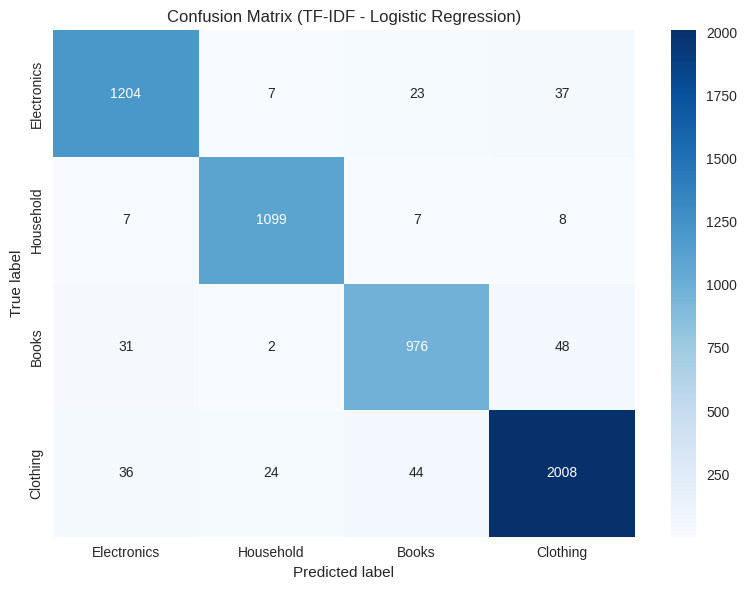

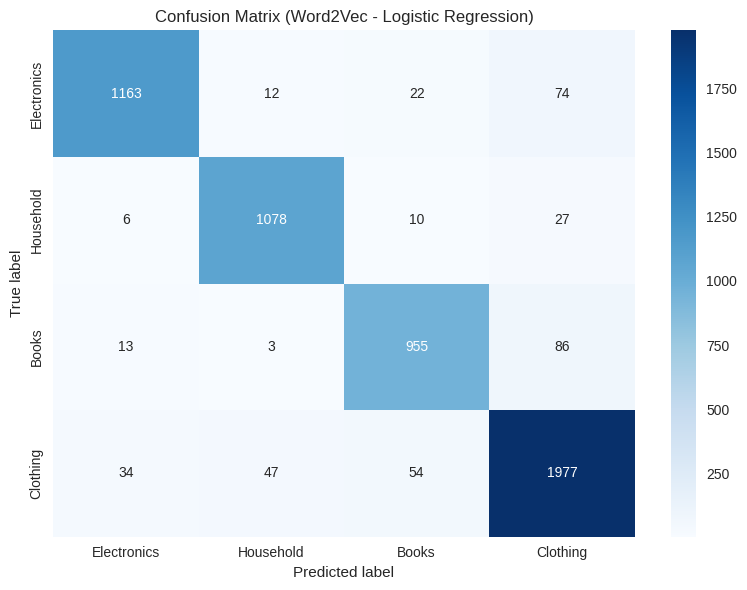


=== Final Results Summary ===

TF-IDF Results:

Logistic Regression:
Train Accuracy: 0.9998
Test Accuracy: 0.9507

Word2Vec Results:

Logistic Regression:
Train Accuracy: 0.9273
Test Accuracy: 0.9302

All results saved to files.
Saved all vectorization components


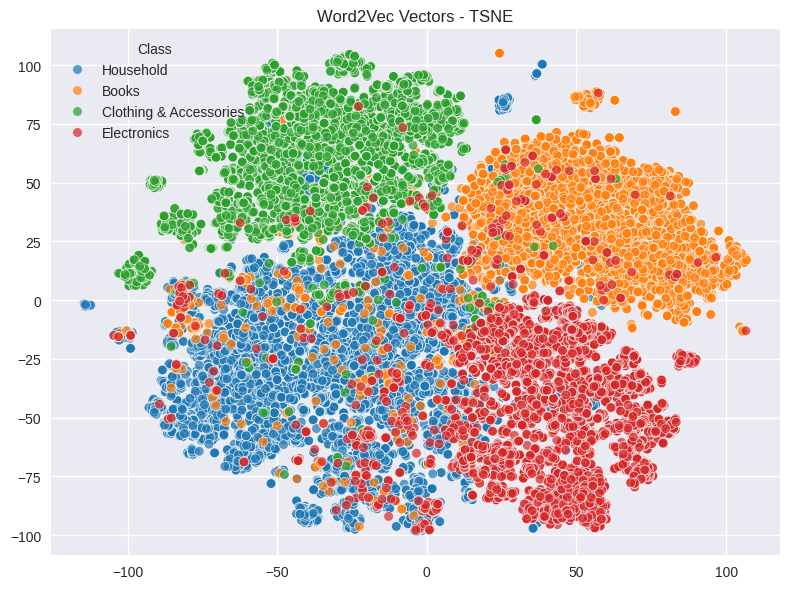


Sample indices predicted as 'Electronics': []


'\nدلایل عملکرد بهتر TF-IDF:\n\nسادگی مدل:\nبرای دیتاست\u200cهای با کلمات کلیدی واضح، مدل\u200cهای ساده\u200cتر مانند TF-IDF + Logistic Regression اغلب بهتر عمل می\u200cکنند\nWord2Vec بیشتر برای کارهای معنایی و کشف روابط پیچیده بین کلمات مناسب است.\n\nماهیت دیتاست:\nدیتاست تجارت الکترونیک (ecommerce) معمولاً شامل کلمات کلیدی متمایزکننده است\nکلمات مانند "processor", "fabric", "hardcover" به راحتی با TF-IDF قابل تشخیص هستند\n\nحفظ اطلاعات آماری:\nTF-IDF فراوانی کلمات را حفظ می\u200cکند که برای طبقه\u200cبندی مهم است\nWord2Vec این اطلاعات را از دست می\u200cدهد\n'

In [5]:
# Create directory for saving models
MODEL_DIR = Path("saved_models")
os.makedirs(MODEL_DIR, exist_ok=True)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Load vectorized data from Phase 2
print("Loading vectorized data...")
OUT_DIR = Path("vectorised")

# Load labels with allow_pickle=True
try:
    labels = np.load(OUT_DIR / "labels.npy", allow_pickle=True)
except Exception as e:
    print(f"Error loading labels: {e}")
    raise

# Load TF-IDF matrix
try:
    tfidf_data = np.load(OUT_DIR / "X_tfidf.npz")
    X_tfidf = csr_matrix((tfidf_data['data'], tfidf_data['indices'],
                        tfidf_data['indptr']), shape=tfidf_data['shape'])
except Exception as e:
    print(f"Error loading TF-IDF matrix: {e}")
    raise

# Load Word2Vec matrix
try:
    X_w2v = np.load(OUT_DIR / "X_w2v.npy", allow_pickle=True)
except Exception as e:
    print(f"Error loading Word2Vec matrix: {e}")
    raise

# Class names for visualization
class_names = ['Electronics', 'Household', 'Books', 'Clothing']

def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=class_names)
    cm = confusion_matrix(y_test, y_pred)
    return model, y_pred, train_accuracy, test_accuracy, report, cm

# TF-IDF Classification
print("\nEvaluating TF-IDF vectors...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # "SVM": SVC(kernel='linear'),
    # "Random Forest": RandomForestClassifier(n_estimators=100)
}
tfidf_results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    model, _, train_acc, test_acc, report, cm = evaluate_model(X_tfidf, labels, model)
    tfidf_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'report': report,
        'cm': cm
    }
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(report)

# Save TF-IDF Logistic Regression model
if "Logistic Regression" in tfidf_results:
    lr_tfidf = tfidf_results["Logistic Regression"]['model']
    joblib.dump(lr_tfidf, MODEL_DIR / "logistic_regression_tfidf.joblib")
    print(f"\nSaved TF-IDF Logistic Regression model to {MODEL_DIR / 'logistic_regression_tfidf.joblib'}")

# Word2Vec Classification
print("\nEvaluating Word2Vec vectors...")
w2v_results = {}
for name, model in models.items():
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000)
    elif name == "SVM":
        model = SVC(kernel='linear')
    else:
        model = RandomForestClassifier(n_estimators=100)
    print(f"\n--- {name} ---")
    model, _, train_acc, test_acc, report, cm = evaluate_model(X_w2v, labels, model)
    w2v_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'report': report,
        'cm': cm
    }
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(report)

# Save Word2Vec Logistic Regression model
if "Logistic Regression" in w2v_results:
    lr_w2v = w2v_results["Logistic Regression"]['model']
    joblib.dump(lr_w2v, MODEL_DIR / "logistic_regression_w2v.joblib")
    print(f"\nSaved Word2Vec Logistic Regression model to {MODEL_DIR / 'logistic_regression_w2v.joblib'}")

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

# Best model confusion matrices
best_tfidf = max(tfidf_results.items(), key=lambda x: x[1]['test_accuracy'])
plot_confusion_matrix(best_tfidf[1]['cm'], class_names, f'Confusion Matrix (TF-IDF - {best_tfidf[0]})')

best_w2v = max(w2v_results.items(), key=lambda x: x[1]['test_accuracy'])
plot_confusion_matrix(best_w2v[1]['cm'], class_names, f'Confusion Matrix (Word2Vec - {best_w2v[0]})')

# Results Summary
print("\n=== Final Results Summary ===")
print("\nTF-IDF Results:")
for name, res in tfidf_results.items():
    print(f"\n{name}:")
    print(f"Train Accuracy: {res['train_accuracy']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")

print("\nWord2Vec Results:")
for name, res in w2v_results.items():
    print(f"\n{name}:")
    print(f"Train Accuracy: {res['train_accuracy']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")

# Save results
with open('classification_results.txt', 'w') as f:
    f.write("=== TF-IDF Results ===\n")
    for name, res in tfidf_results.items():
        f.write(f"\n{name}:\nTrain Accuracy: {res['train_accuracy']:.4f}\n")
        f.write(f"Test Accuracy: {res['test_accuracy']:.4f}\n")
        f.write(res['report'] + "\n")
    f.write("\n=== Word2Vec Results ===\n")
    for name, res in w2v_results.items():
        f.write(f"\n{name}:\nTrain Accuracy: {res['train_accuracy']:.4f}\n")
        f.write(f"Test Accuracy: {res['test_accuracy']:.4f}\n")
        f.write(res['report'] + "\n")
print("\nAll results saved to files.")

joblib.dump(vocab, OUT_DIR / "vocab.joblib")
joblib.dump(IDF, OUT_DIR / "idf_values.joblib")

# Save Word2Vec model
w2v_model.save(str(OUT_DIR / "word2vec.model"))

print("Saved all vectorization components")

# Visualize high-dimensional vectors
def plot_vector_space(X, labels, title, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        raise ValueError("Unknown method")
    X_reduced = reducer.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='tab10', alpha=0.7)
    plt.title(f"{title} - {method.upper()}")
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}_{method}.png", dpi=300)
    plt.show()

plot_vector_space(X_w2v, labels, "Word2Vec Vectors", method='tsne')
# plot_vector_space(X_tfidf, labels, "TF-IDF Vectors", method='pca')

# Inspect predicted samples from best W2V model
best_model_name = best_w2v[0]
best_model = models[best_model_name] if best_model_name in models else RandomForestClassifier()
_, y_pred, _, _, _, _ = evaluate_model(X_w2v, labels, best_model)
target_class = 0  # Example: Electronics
sample_indices = np.where(y_pred == target_class)[0][:5]
print(f"\nSample indices predicted as '{class_names[target_class]}':", sample_indices)


"""
دلایل عملکرد بهتر TF-IDF:

سادگی مدل:
برای دیتاست‌های با کلمات کلیدی واضح، مدل‌های ساده‌تر مانند TF-IDF + Logistic Regression اغلب بهتر عمل می‌کنند
Word2Vec بیشتر برای کارهای معنایی و کشف روابط پیچیده بین کلمات مناسب است.

ماهیت دیتاست:
دیتاست تجارت الکترونیک (ecommerce) معمولاً شامل کلمات کلیدی متمایزکننده است
کلمات مانند "processor", "fabric", "hardcover" به راحتی با TF-IDF قابل تشخیص هستند

حفظ اطلاعات آماری:
TF-IDF فراوانی کلمات را حفظ می‌کند که برای طبقه‌بندی مهم است
Word2Vec این اطلاعات را از دست می‌دهد
"""


Classes: ['Books', 'Clothing & Accessories', 'Electronics', 'Household']
Using all 27802 data points
Data shape: (27802, 58116)
Reducing to 100 dimensions with SVD...
Applying t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipython-input-1975320138.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=df, x='x', y='y', hue='class',


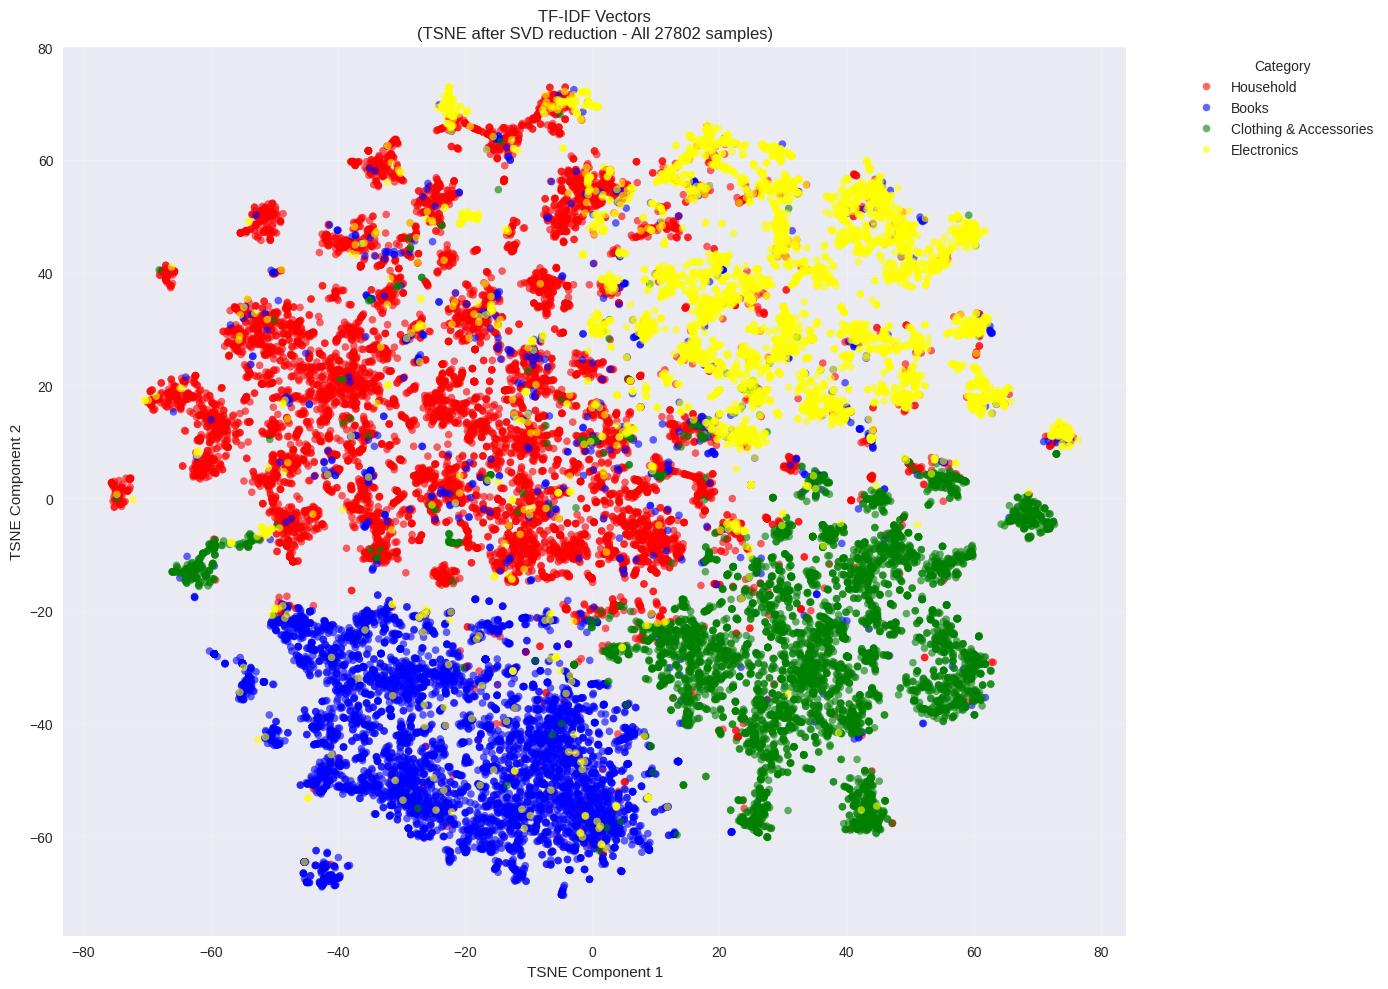

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd

def plot_tfidf_improved(X, labels, title, method='pca'):
    """
    Improved visualization for TF-IDF vectors with proper preprocessing
    """
    # Convert string labels to numerical
    if isinstance(labels[0], str):
        label_encoder = LabelEncoder()
        labels_numeric = label_encoder.fit_transform(labels)
        class_names = label_encoder.classes_
        print(f"Classes: {list(class_names)}")
    else:
        labels_numeric = labels
        class_names = np.unique(labels)

    # Use all data (no sampling)
    if hasattr(X, 'issparse') and X.issparse():
        X_dense = X.toarray()
    else:
        X_dense = X

    print(f"Using all {X_dense.shape[0]} data points")
    print(f"Data shape: {X_dense.shape}")

    # Step 1: Reduce dimensionality first using SVD (essential for TF-IDF)
    n_components = min(100, X_dense.shape[1]-1)
    print(f"Reducing to {n_components} dimensions with SVD...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X_dense)

    # Step 2: Normalize the reduced vectors
    X_reduced = Normalizer().fit_transform(X_reduced)

    # Step 3: Apply final dimensionality reduction
    if method == 'pca':
        print("Applying PCA...")
        reducer = PCA(n_components=2, random_state=42)
        X_final = reducer.fit_transform(X_reduced)
        print(f"Explained variance ratio: {reducer.explained_variance_ratio_.sum():.3f}")

    elif method == 'tsne':
        print("Applying t-SNE...")
        # For large datasets, use higher perplexity and more iterations
        reducer = TSNE(n_components=2, random_state=42,
                      perplexity=min(50, X_reduced.shape[0]//10),
                      learning_rate=200, n_iter=1000,
                      init='random')  # Use random init for stability
        X_final = reducer.fit_transform(X_reduced)

    # Create the plot
    plt.figure(figsize=(14, 10))  # Larger figure for more data points

    # Create custom color palette with red, blue, green, yellow
    custom_palette = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']

    # Use seaborn for better categorical plotting
    df = pd.DataFrame({
        'x': X_final[:, 0],
        'y': X_final[:, 1],
        'class': [class_names[l] for l in labels_numeric] if isinstance(labels[0], str) else labels_numeric
    })

    # Use smaller point size and adjust alpha for better visibility with many points
    sns.scatterplot(data=df, x='x', y='y', hue='class',
                   palette=custom_palette, alpha=0.6, s=30, edgecolor='none')

    plt.title(f"{title}\n({method.upper()} after SVD reduction - All {X_dense.shape[0]} samples)")
    plt.xlabel(f"{method.upper()} Component 1")
    plt.ylabel(f"{method.upper()} Component 2")
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}_{method}_all_data.png", dpi=300, bbox_inches='tight')
    plt.show()

    return X_final

# Plot all data with PCA
X_pca = plot_tfidf_improved(X_tfidf, labels, "TF-IDF Vectors", method='tsne')

# You can also try with t-SNE (but be warned: this will be slow for large datasets)
# X_tsne = plot_tfidf_improved(X_tfidf, labels, "TF-IDF Vectors", method='tsne')

In [7]:
import pandas as pd
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split

# استفاده از داده‌های قبلاً لود شده - نیازی به خواندن مجدد از فایل نیست
# df قبلاً در کد اصلی لود شده است
# texts = df["clean_text"].astype(str).tolist() - این قبلاً تعریف شده
# labels = df["label"].to_numpy() - این قبلاً تعریف شده

# استفاده از متن اصلی از دیتافریم اصلی (نه clean_text)
texts_original = df["text"].values if "text" in df.columns else df["clean_text"].values
labels_original = df["label"].values

# Map class labels (string -> index)
class_names = ['Electronics', 'Household', 'Books', 'Clothing']
label_to_index = {name: i for i, name in enumerate(class_names)}

# Train/test split (شامل متن اصلی)
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(
    X_w2v, labels_original, texts_original, test_size=0.2, random_state=42
)

# Best Word2Vec model - استفاده از مدلی که قبلاً آموزش داده شده
best_model_name = max(w2v_results.items(), key=lambda x: x[1]['test_accuracy'])[0]
best_model = w2v_results[best_model_name]['model']

# Predict
y_pred = best_model.predict(X_test)

# Find mismatches
mismatches = np.where(y_test != y_pred)[0]

# Collect 3 mismatches per class
samples_per_class = defaultdict(list)
for idx in mismatches:
    true_label_str = y_test[idx]
    pred_label_str = y_pred[idx]

    # تبدیل برچسب رشته‌ای به اندیس عددی
    true_label_idx = None
    for class_idx, class_name in enumerate(class_names):
        if class_name == true_label_str:
            true_label_idx = class_idx
            break

    if true_label_idx is not None and len(samples_per_class[true_label_idx]) < 3:
        samples_per_class[true_label_idx].append(
            (idx, true_label_str, pred_label_str, texts_test[idx])
        )

# Display results
print("\n=== Mismatched Samples (word2vec) ===")
for true_class_idx, samples in samples_per_class.items():
    print(f"\nClass: {class_names[true_class_idx]}")
    for idx, true_label_str, pred_label_str, text in samples:
        print(f"Index: {idx}")
        print(f"True: {true_label_str} | Predicted: {pred_label_str}")
        print(f"Text: {text}...")  # نمایش فقط 200 کاراکتر اول
        print(f"{'-'*60}")


=== Mismatched Samples (word2vec) ===

Class: Household
Index: 45
True: Household | Predicted: Books
Text: The Fairytale Hairdresser and Rapunzel: Playbox Review "With bold line, strong colour pictures and witty, easy-to-read narrative, this is an ideal book for the newly-independent reader" (Irish Examiner) 				    	 					 About the Author Abie Longstaff (Author)  Abie Longstaff is the eldest of six children and grew up in Australia, Hong Kong and France. She knows all about squabbling, chaos and bossing younger sisters around. So she logically began her career as a barrister. She started writing when her children were born. Her favourite childhood books were Hating Alison Ashley, A Little Princess, Maura's Angel and The Black Stallion and she sneakily reads them again sometimes. Abie lives in North London with her family and a very pesky cocker spaniel who chews the post.Lauren Beard (Illustrator)  Lauren Beard is an illustrator based in Manchester. As a young girl she always loved 

In [10]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# استفاده از داده‌های قبلاً لود شده - نیازی به خواندن مجدد از فایل نیست
# df قبلاً در کد اصلی لود شده است

# استفاده از متن اصلی و لیبل‌های موجود
texts_original = df["text"].values if "text" in df.columns else df["clean_text"].values
labels_original = df["label"].values

# Split raw text (not features yet!)
texts_train, texts_test, y_train, y_test = train_test_split(
    texts_original, labels_original, test_size=0.2, random_state=42
)

# Use the same vectorizer for both train & test
vectorizer = TfidfVectorizer(max_features=10000)  # افزایش max_features برای عملکرد بهتر
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# Train model با استفاده از بهترین پارامترهای TF-IDF
best_tfidf_model = LogisticRegression(max_iter=1000, random_state=42)
best_tfidf_model.fit(X_train, y_train)

# Predict
y_pred = best_tfidf_model.predict(X_test)

# Map labels
class_names = ['Electronics', 'Household', 'Books', 'Clothing']
label_to_index = {name: i for i, name in enumerate(class_names)}

# Find mismatches
mismatches = np.where(y_test != y_pred)[0]

# Collect 3 mismatches per class
samples_per_class = defaultdict(list)
for idx in mismatches:
    true_label_str = y_test[idx]
    pred_label_str = y_pred[idx]

    # پیدا کردن اندیس کلاس واقعی
    true_label_idx = None
    for class_idx, class_name in enumerate(class_names):
        if class_name == true_label_str:
            true_label_idx = class_idx
            break

    if true_label_idx is not None and len(samples_per_class[true_label_idx]) < 3:
        samples_per_class[true_label_idx].append(
            (idx, true_label_str, pred_label_str, texts_test[idx])
        )

# Display results
print("\n=== Mismatched Samples (TF-IDF) ===")
print(f"Total mismatches: {len(mismatches)} out of {len(y_test)} test samples")
print(f"Accuracy: {(len(y_test) - len(mismatches)) / len(y_test):.3f}")

for true_class_idx, samples in samples_per_class.items():
    print(f"\nClass: {class_names[true_class_idx]}")
    for sample_idx, (idx, true_label_str, pred_label_str, text) in enumerate(samples):
        print(f"\nSample {sample_idx + 1}:")
        print(f"Index: {idx}")
        print(f"True: {true_label_str} | Predicted: {pred_label_str}")
        print(f"Text: {text}...")
        print(f"{'-'*60}")

# همچنین می‌توانید نمونه‌های درست طبقه‌بندی شده را هم ببینید
correct_indices = np.where(y_test == y_pred)[0]
print(f"\n=== Correctly Classified Samples (TF-IDF) ===")
print(f"Total correct: {len(correct_indices)}")

# نمایش چند نمونه درست
print("\nFew correctly classified samples:")
for i in range(min(3, len(correct_indices))):
    idx = correct_indices[i]
    print(f"Index: {idx}")
    print(f"True: {y_test[idx]} | Predicted: {y_pred[idx]}")
    print(f"Text: {texts_test[idx]}...")
    print(f"{'-'*40}")


=== Mismatched Samples (TF-IDF) ===
Total mismatches: 254 out of 5561 test samples
Accuracy: 0.954

Class: Household

Sample 1:
Index: 45
True: Household | Predicted: Books
Text: The Fairytale Hairdresser and Rapunzel: Playbox Review "With bold line, strong colour pictures and witty, easy-to-read narrative, this is an ideal book for the newly-independent reader" (Irish Examiner) 				    	 					 About the Author Abie Longstaff (Author)  Abie Longstaff is the eldest of six children and grew up in Australia, Hong Kong and France. She knows all about squabbling, chaos and bossing younger sisters around. So she logically began her career as a barrister. She started writing when her children were born. Her favourite childhood books were Hating Alison Ashley, A Little Princess, Maura's Angel and The Black Stallion and she sneakily reads them again sometimes. Abie lives in North London with her family and a very pesky cocker spaniel who chews the post.Lauren Beard (Illustrator)  Lauren Beard 

# Predict user input

In [ ]:
from gensim.models import Word2Vec
import joblib
from collections import Counter

# Define class names (must match your training labels)
class_names = ['Electronics', 'Household', 'Books', 'Clothing']

# Load models and vectorizers
print("Loading models...")
try:
    # Load TF-IDF components
    vocab = joblib.load(OUT_DIR / "vocab.joblib")
    idf_values = joblib.load(OUT_DIR / "idf_values.joblib")

    # Load Word2Vec model
    w2v_model = Word2Vec.load(str(OUT_DIR / "word2vec.model"))

    # Load classifiers
    lr_tfidf = joblib.load(MODEL_DIR / "logistic_regression_tfidf.joblib")
    lr_w2v = joblib.load(MODEL_DIR / "logistic_regression_w2v.joblib")

    print("All models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    raise

def predict_text(text):
    # Clean and tokenize
    cleaned = clean_text(text)
    tokens = cleaned.split()

    # TF-IDF vectorization
    tf = Counter(tokens)
    row, col, data = [], [], []
    for token, count in tf.items():
        if token in vocab:
            col_idx = vocab[token]
            row.append(0)
            col.append(col_idx)
            data.append(count * idf_values[col_idx])
    tfidf_vec = csr_matrix((data, (row, col)), shape=(1, len(vocab)))

    # Word2Vec vectorization
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    w2v_vec = np.mean(vectors, axis=0).reshape(1, -1) if vectors else np.zeros((1, w2v_model.vector_size))

    # Get predictions (directly use string labels)
    tfidf_pred = lr_tfidf.predict(tfidf_vec)[0]
    w2v_pred = lr_w2v.predict(w2v_vec)[0]

    # Get probabilities
    tfidf_probs = lr_tfidf.predict_proba(tfidf_vec)[0]
    w2v_probs = lr_w2v.predict_proba(w2v_vec)[0]

    # Create probability dictionaries
    prob_dict_tfidf = {}
    prob_dict_w2v = {}

    # Check if probabilities are available (some models might not have them)
    if hasattr(lr_tfidf, 'classes_'):
        for i, class_name in enumerate(lr_tfidf.classes_):
            prob_dict_tfidf[class_name] = f"{tfidf_probs[i]:.2%}"
    else:
        prob_dict_tfidf = {class_names[i]: f"{prob:.2%}" for i, prob in enumerate(tfidf_probs)}

    if hasattr(lr_w2v, 'classes_'):
        for i, class_name in enumerate(lr_w2v.classes_):
            prob_dict_w2v[class_name] = f"{w2v_probs[i]:.2%}"
    else:
        prob_dict_w2v = {class_names[i]: f"{prob:.2%}" for i, prob in enumerate(w2v_probs)}

    return {
        'text': text,
        'tfidf_pred': tfidf_pred,
        'tfidf_probs': prob_dict_tfidf,
        'w2v_pred': w2v_pred,
        'w2v_probs': prob_dict_w2v
    }

# Interactive prediction
print("\nEnter text to classify (type 'quit' to exit):")
while True:
    text = input("\nInput: ")
    if text.lower() == 'quit':
        break
    if not text.strip():
        print("Please enter text")
        continue

    result = predict_text(text)
    print(f"\nTF-IDF Prediction: {result['tfidf_pred']}")
    print("TF-IDF Probabilities:")
    for cat, prob in result['tfidf_probs'].items():
        print(f"  {cat}: {prob}")

    print(f"\nWord2Vec Prediction: {result['w2v_pred']}")
    print("Word2Vec Probabilities:")
    for cat, prob in result['w2v_probs'].items():
        print(f"  {cat}: {prob}")
